In [1]:
import numpy as np

In [331]:
import pandas as pd
import numpy as np
import sys, os
import importlib
sys.path.insert(0, os.path.abspath('../'))
import textmining.cluster_analysis as cluster_analysis
import textmining.lexicons as lexicons
import textmining.machine_learning as machine_learning
import textmining.significance_testing as significance_testing
import debateorg.loader as loader
import debateorg.properties as prop  
import debateorg.processor as proc  

importlib.reload(cluster_analysis)
importlib.reload(lexicons)
importlib.reload(machine_learning)
importlib.reload(significance_testing)
importlib.reload(loader)
importlib.reload(prop)
importlib.reload(proc)


import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

sns.reset_defaults()
sns.set(
    rc={'figure.figsize':(6,4)}, 
    #style="white" # nicer layout
)

In [332]:
processor = proc.Process()

In [334]:

liberal_arguments_df, liberal_not_found = processor.get_ideology_based_voter_participant_df(prop.LIBERAL_IDEOLOGY)
conservative_arguments_df, conservative_not_found = processor.get_ideology_based_voter_participant_df(prop.CONSERVATIVE_IDEOLOGY)

# Extract Features

## LIWC

In [10]:
liwc_conservative_df = pd.read_csv('../data/debateorg_arguments_txt/liwc_conservatives.csv')
liwc_liberal_df = pd.read_csv('../data/debateorg_arguments_txt/liwc_liberal.csv')

In [26]:
liwc_conservative_df.columns


Index(['Filename', 'Segment', 'WC', 'Analytic', 'Clout', 'Authentic', 'Tone',
       'WPS', 'Sixltr', 'Dic', 'function', 'pronoun', 'ppron', 'i', 'we',
       'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb',
       'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number',
       'quant', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'social',
       'family', 'friend', 'female', 'male', 'cogproc', 'insight', 'cause',
       'discrep', 'tentat', 'certain', 'differ', 'percept', 'see', 'hear',
       'feel', 'bio', 'body', 'health', 'sexual', 'ingest', 'drives',
       'affiliation', 'achieve', 'power', 'reward', 'risk', 'focuspast',
       'focuspresent', 'focusfuture', 'relativ', 'motion', 'space', 'time',
       'work', 'leisure', 'home', 'money', 'relig', 'death', 'informal',
       'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'AllPunc', 'Period',
       'Comma', 'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash', 'Quote',
       'Apostro', 'Paren

In [28]:
def add_id(row):
    row['numeric_id'] = int(row['Filename'].split('_')[1].split('.')[0])
    return row

liwc_conservative_df = liwc_conservative_df.apply(add_id, axis=1)
liwc_liberal_df = liwc_liberal_df.apply(add_id, axis=1)

liwc_conservative_df.set_index('numeric_id', inplace = True)
liwc_liberal_df.set_index('numeric_id', inplace = True)

In [31]:
liwc_liberal_df = liwc_liberal_df.add_prefix('liwc_')
liwc_conservative_df = liwc_conservative_df.add_prefix('liwc_')

In [44]:
liwc_liberal_df.reset_index().to_csv('../data/extracted_features/liwc_liberal.csv', index=False)
liwc_conservative_df.reset_index().to_csv('../data/extracted_features/liwc_conservative.csv', index=False)b

In [47]:
liwc_liberal_df.drop(['liwc_Filename'], axis=1, inplace=True)
liwc_conservative_df.drop(['liwc_Filename'], axis=1, inplace=True)

In [61]:
len(liwc_conservative_df.columns)

94

## nrc

In [33]:
liberal_arguments_df.head()

,id,debate_id,p_name,effects,effect_count,top_effect,effect,category,round,argument
numeric_id,,,,,,,,,,
0,.-.-.-Ha-YOURE-GOING-DOWN-BEEM0R/1/_Logical-Ma...,.-.-.-Ha-YOURE-GOING-DOWN-BEEM0R/1/,Logical-Master,ineffective,{'ineffective': 1},ineffective,ineffective,Miscellaneous,0,\n \r\nRESOLVED: It is impossible not to cons...
1,.-.-.-Ha-YOURE-GOING-DOWN-BEEM0R/1/_Logical-Ma...,.-.-.-Ha-YOURE-GOING-DOWN-BEEM0R/1/,Logical-Master,ineffective,{'ineffective': 1},ineffective,ineffective,Miscellaneous,1,"\n \r\nOkay, just now reading the round, it w..."
2,.-.-.-Ha-YOURE-GOING-DOWN-BEEM0R/1/_Logical-Ma...,.-.-.-Ha-YOURE-GOING-DOWN-BEEM0R/1/,Logical-Master,ineffective,{'ineffective': 1},ineffective,ineffective,Miscellaneous,2,\n \r\n--->RE:Since my opponent has left it u...
3,.-.-.-Ha-YOURE-GOING-DOWN-BEEM0R/1/_Logical-Ma...,.-.-.-Ha-YOURE-GOING-DOWN-BEEM0R/1/,Logical-Master,ineffective,{'ineffective': 1},ineffective,ineffective,Miscellaneous,3,\n \r\nCONSCIOUS SECTION: \n \r\nLadies and...
4,.-.-.-Ha-YOURE-GOING-DOWN-BEEM0R/1/_beem0r_0,.-.-.-Ha-YOURE-GOING-DOWN-BEEM0R/1/,beem0r,ineffective,{'ineffective': 1},ineffective,ineffective,Miscellaneous,0,\n \r\nI would eplain the vast differences be...


In [42]:

nrc_liberal_df  = liberal_arguments_df[['argument']].copy()
nrc_conservative_df = conservative_arguments_df[['argument']].copy()


In [43]:
#nrc

nrc_liberal_df = lexicons.count_nrc_emotions_and_sentiments(nrc_liberal_df, text_column= 'argument')
nrc_conservative_df = lexicons.count_nrc_emotions_and_sentiments(nrc_conservative_df, text_column= 'argument')

In [142]:
nrc_liberal_df.reset_index().to_csv('../data/extracted_features/nrc_liberal.csv', index=False)
nrc_conservative_df.reset_index().to_csv('../data/extracted_features/nrc_conservative.csv', index=False)

In [55]:
len(nrc_conservative_df) # 120565
len(nrc_liberal_df) # 75098

75098

In [324]:
len(nrc_conservative_df.columns)
len(nrc_liberal_df.columns)
#pd.read_csv('../data/extracted_features/nrc_liberal.csv', index_col='numeric_id')

,argument,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_sadness,nrc_surprise,nrc_trust,nrc_ratio,nrc_negative,nrc_positive
numeric_id,,,,,,,,,,,,
0,\n \r\nRESOLVED: It is impossible not to cons...,7,6,4,4,4,3,1,14,0.33962,11,23
1,"\n \r\nOkay, just now reading the round, it w...",5,3,2,3,0,3,1,0,0.36810,9,7
2,\n \r\n--->RE:Since my opponent has left it u...,12,17,15,16,7,17,5,11,0.31579,24,38
3,\n \r\nCONSCIOUS SECTION: \n \r\nLadies and...,4,3,2,2,2,2,1,7,0.28458,6,20
4,\n \r\nI would eplain the vast differences be...,5,8,7,7,1,8,4,2,0.31076,13,10
...,...,...,...,...,...,...,...,...,...,...,...,...
75093,"\n \r\nI am talking about human embryology, c...",1,2,1,0,1,2,0,0,0.52542,4,5
75094,\n \r\nYou seem to be avoiding the crux of th...,0,0,0,1,0,0,0,0,0.48980,0,1
75095,\n \n I accept. The BoP shall be on my oppon...,8,4,2,3,1,1,1,6,0.27230,18,4


## MPQA Arg

In [319]:
mpqa_arg_liberal_df  = liberal_arguments_df[['argument']].copy()
mpqa_arg_conservative_df = conservative_arguments_df[['argument']].copy()
len(mpqa_arg_conservative_df)

101932

In [320]:
#mpqa arg

mpqa_arg_liberal_df = lexicons.count_mpqa_arg(mpqa_arg_liberal_df, text_column='argument',prefix='mpqa_arg_')
mpqa_arg_conservative_df = lexicons.count_mpqa_arg(mpqa_arg_conservative_df, text_column='argument',prefix='mpqa_arg_')

In [322]:
mpqa_arg_liberal_df.reset_index().to_csv('../data/extracted_features/mpqa_arg_liberal.csv', index=False)
mpqa_arg_liberal_df.reset_index().to_csv('../data/extracted_features/mpqa_arg_conservative.csv', index=False)

## EMPATH

In [326]:
#empath
empath_liberal_df = liberal_arguments_df[['argument']].copy()
empath_conservative_df = conservative_arguments_df[['argument']].copy()

empath_liberal_df = lexicons.count_empath(empath_liberal_df, text_column='argument',prefix='empath_')
empath_conservative_df = lexicons.count_empath(empath_conservative_df, text_column='argument',prefix='empath_')

In [327]:
empath_liberal_df.reset_index().to_csv('../data/extracted_features/empath_liberal.csv', index=False)
empath_conservative_df.reset_index().to_csv('../data/extracted_features/empath_conservative.csv', index=False)

In [337]:
empath_liberal_df.describe()

,empath__help,empath__office,empath__dance,empath__money,empath__wedding,empath__domestic_work,empath__sleep,empath__medical_emergency,empath__cold,empath__hate,...,empath__weapon,empath__children,empath__monster,empath__ocean,empath__giving,empath__contentment,empath__writing,empath__rural,empath__positive_emotion,empath__musical
count,66844.000000,66844.000000,66844.000000,66844.000000,66844.000000,66844.000000,66844.000000,66844.000000,66844.000000,66844.000000,...,66844.000000,66844.000000,66844.000000,66844.000000,66844.000000,66844.000000,66844.000000,66844.000000,66844.000000,66844.000000
mean,0.002338,0.000738,0.000681,0.002418,0.002032,0.000735,0.000539,0.001060,0.000891,0.001834,...,0.001390,0.003120,0.000506,0.000397,0.006869,0.000661,0.001707,0.000520,0.004588,0.001196
std,0.006648,0.003336,0.005313,0.007352,0.008235,0.003996,0.004055,0.004736,0.007662,0.007368,...,0.007621,0.008890,0.003259,0.003646,0.026103,0.003386,0.006327,0.002809,0.011062,0.006618
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.002147,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.002649,0.000000,0.000000,0.001314,0.001257,0.000000,0.000000,0.000000,0.000000,0.001124,...,0.000000,0.002672,0.000000,0.000000,0.006803,0.000000,0.001142,0.000000,0.005388,0.000000
max,0.500000,0.200000,0.500000,0.250000,0.500000,0.333333,0.250000,0.332632,1.000000,0.500000,...,1.000000,0.333333,0.200000,0.333333,1.000000,0.200000,0.333333,0.333333,0.333333,0.500000


# Cluster Analysis

In [264]:
import imblearn
print(imblearn.__version__)

def undersample(df, strategy='.5'):
    col=df.columns
    features=col.tolist() 
    feature=features[:-1] 
    target=features[-1]
    X=df.loc[:,feature]  
    y=df.loc[:,target]
    
    undersample = imblearn.under_sampling.RandomUnderSampler(random_state=0)#, sampling_strategy=strategy)
    X_under, y_under = undersample.fit_resample(X, y)
    print(Counter(y_under))
    return pd.concat([X_under,y_under],axis=1)

0.7.0


In [210]:
cons_valid_indices = conservative_arguments_df.index.values.tolist()
lib_valid_indices = liberal_arguments_df.index.values.tolist()

In [211]:
len(cons_valid_indices)

102069

In [212]:
conservative_features_df = nrc_conservative_df.merge(liwc_conservative_df, how='inner', left_index= True, right_index=True)
liberal_features_df = nrc_liberal_df.merge(liwc_liberal_df, how='inner', left_index= True, right_index=True)

conservative_features_df = conservative_features_df[conservative_features_df.index.isin(cons_valid_indices)]
liberal_features_df = liberal_features_df[liberal_features_df.index.isin(lib_valid_indices)]

conservative_features_df.drop(['argument'], axis=1, inplace=True)
liberal_features_df.drop(['argument'], axis=1, inplace=True)
len(conservative_features_df)
conservative_features_df.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_sadness,nrc_surprise,nrc_trust,nrc_ratio,nrc_negative,...,liwc_Comma,liwc_Colon,liwc_SemiC,liwc_QMark,liwc_Exclam,liwc_Dash,liwc_Quote,liwc_Apostro,liwc_Parenth,liwc_OtherP
numeric_id,,,,,,,,,,,,,,,,,,,,,
0,5,8,7,7,1,8,4,2,0.31076,13,...,5.51,0.79,0.00,0.0,0.0,1.97,4.72,2.76,0.00,2.36
1,11,7,9,11,0,6,1,3,0.28571,13,...,4.80,0.00,0.00,0.0,0.0,1.41,0.56,2.54,1.13,0.00
2,18,23,18,21,3,9,2,13,0.33444,24,...,7.95,0.17,0.17,0.0,0.0,3.31,0.66,1.99,0.00,2.15
3,11,6,8,6,2,4,1,9,0.21767,12,...,6.77,0.00,0.00,0.0,0.0,1.75,0.75,3.13,0.00,1.63
4,1,1,1,1,2,1,0,1,0.19231,1,...,9.62,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00


In [225]:
def prepare_data(df,  normalize=True, normalizing_method="sqrt"):#only_numeric for clustering
    df_ = df.copy()
    df_.fillna(0.0, inplace=True)
    ## Normalize for only training set for discourse level
    df_, _ = machine_learning.clip_outliers(df_, df_test =None, lower_percentile=1,  upper_percentile=99)
    if normalize:
        df_, _ = machine_learning.normalize(df_, None, normalizing_method=normalizing_method)
    return df_

In [230]:
def run_cluster_analysis(df,desc = "default"):

    ## INIT
    df_ = prepare_data(df,  normalize=True, normalizing_method="standard")

    print(df_.index.name)
    print('filtering our features wich has 75% of entries without a values')
    df_ = df_.loc[:,~df_.columns.duplicated()]
    desc_df= df_.describe().T
    desc_df= desc_df[desc_df['75%'] > 0]

    df_ = df_[desc_df.index.values]
    print(len(df_))
    #desc_.index.values 
    ## CLUSTER ANALYSIS
    optimal_k = cluster_analysis.elbow(df_,normalize = True, visualize=True, k_range= range(2, 10) )
    print('optimal_k: ', optimal_k)
    analyzer_cos_kmeans = cluster_analysis.Analyzer(df_)
    analyzer_cos_kmeans.set_algorithm(algorithm= 'cosine_kmeans', algorithm_args={'n_clusters':optimal_k})
    analyzer_cos_kmeans.evaluate_silhouette_score(metric="cosine")
    #cluster_lbl_ = analyzer_cos_kmeans.predict_labels('id')

    ## PREDICT LABEL
    predicted_df = analyzer_cos_kmeans.predict_labels('numeric_id', apply=True)
    print('Plotting for:')
    print(analyzer_cos_kmeans.top_vars('numeric_id', top=4, plot=True))
    

    ## Significance Testing - 
    ## H0: There is no significance difference between features (e.g. Liwc tone)
    ##  across all clusters for ONE discourse level/setting
    ## EXAMPLE of H0: There is no significance difference between Liwc emotional tone 
    ##                across all cluster types for LEAD.
    significancy_result =significance_testing.significance(analyzer_cos_kmeans.df, #save=False, 
                                      #desc='significance_tests/{}/sigtest_{}'.format(desc, discourse_level),
                                      independent_var='cluster')

    return significancy_result, predicted_df

getting only numeric features from the training set...
There are 105  numeric features out of 105
Normalizing by using standard scaler...
numeric_id
filtering our features wich has 75% of entries without a values
102069


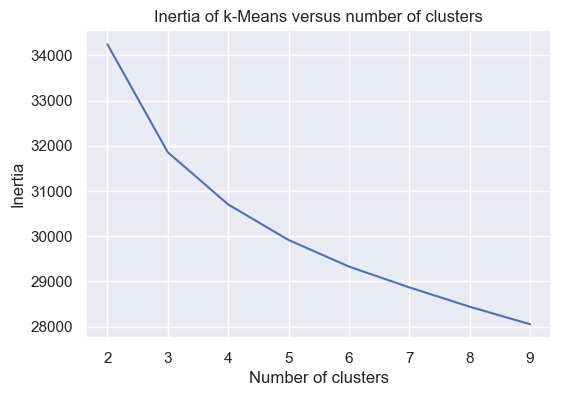

optimal_k:  4
cosine_kmeans - silhouette_score: 0.09056645075232031
Index(['numeric_id', 'nrc_anger', 'nrc_anticipation', 'nrc_disgust',
       'nrc_fear', 'nrc_joy', 'nrc_sadness', 'nrc_surprise', 'nrc_trust',
       'nrc_ratio', 'nrc_negative', 'nrc_positive', 'liwc_Segment', 'liwc_WC',
       'liwc_Analytic', 'liwc_Clout', 'liwc_Authentic', 'liwc_Tone',
       'liwc_WPS', 'liwc_Sixltr', 'liwc_Dic', 'liwc_function', 'liwc_pronoun',
       'liwc_ppron', 'liwc_i', 'liwc_we', 'liwc_you', 'liwc_shehe',
       'liwc_they', 'liwc_ipron', 'liwc_article', 'liwc_prep', 'liwc_auxverb',
       'liwc_adverb', 'liwc_conj', 'liwc_negate', 'liwc_verb', 'liwc_adj',
       'liwc_compare', 'liwc_interrog', 'liwc_number', 'liwc_quant',
       'liwc_affect', 'liwc_posemo', 'liwc_negemo', 'liwc_anx', 'liwc_anger',
       'liwc_sad', 'liwc_social', 'liwc_male', 'liwc_cogproc', 'liwc_insight',
       'liwc_cause', 'liwc_discrep', 'liwc_tentat', 'liwc_certain',
       'liwc_differ', 'liwc_percept', 'liwc_se

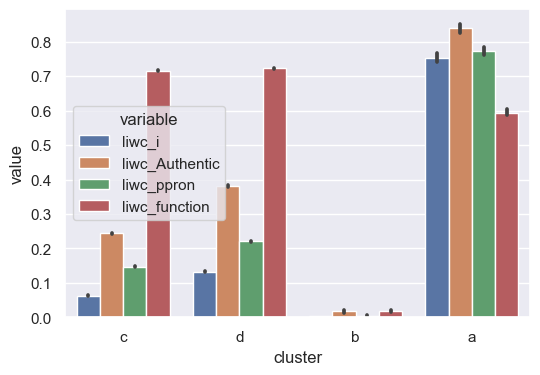

          Variable       Var
23          liwc_i  0.301291
15  liwc_Authentic  0.300396
22      liwc_ppron   0.29189
20   liwc_function  0.290608
data has 102069 instances
bonforrini_threshold:  0.008333333333333333
exception for feature  All numbers are identical in kruskal


In [231]:
conservative_significancy_result, conservative_predicted_df = run_cluster_analysis(conservative_features_df)

<AxesSubplot:xlabel='effect'>

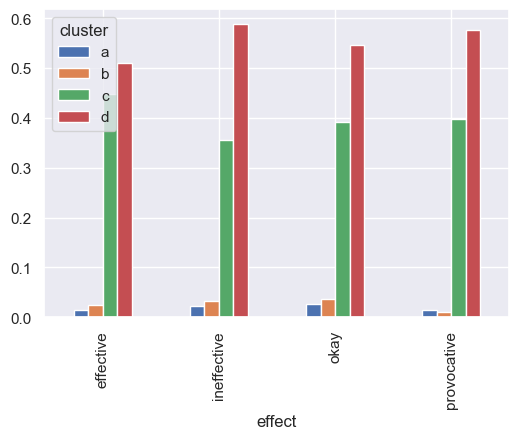

In [232]:
conservative_effect_cluster_df = conservative_predicted_df.merge(conservative_arguments_df[['effect']], 
                                how='inner', left_index= True, right_index=True)
pd.crosstab(conservative_effect_cluster_df['effect'], conservative_effect_cluster_df['cluster'], normalize='index').plot(kind='bar')




getting only numeric features from the training set...
There are 105  numeric features out of 105
Normalizing by using standard scaler...
numeric_id
filtering our features wich has 75% of entries without a values
66915


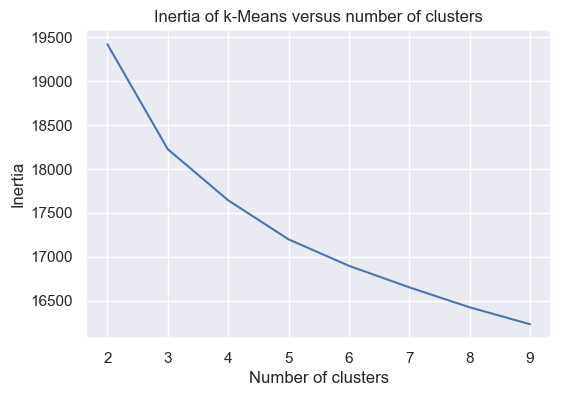

optimal_k:  4
cosine_kmeans - silhouette_score: 0.06953542299346827
Index(['numeric_id', 'nrc_anger', 'nrc_anticipation', 'nrc_disgust',
       'nrc_fear', 'nrc_joy', 'nrc_sadness', 'nrc_surprise', 'nrc_trust',
       'nrc_ratio', 'nrc_negative', 'nrc_positive', 'liwc_Segment', 'liwc_WC',
       'liwc_Analytic', 'liwc_Clout', 'liwc_Authentic', 'liwc_Tone',
       'liwc_WPS', 'liwc_Sixltr', 'liwc_Dic', 'liwc_function', 'liwc_pronoun',
       'liwc_ppron', 'liwc_i', 'liwc_we', 'liwc_you', 'liwc_shehe',
       'liwc_they', 'liwc_ipron', 'liwc_article', 'liwc_prep', 'liwc_auxverb',
       'liwc_adverb', 'liwc_conj', 'liwc_negate', 'liwc_verb', 'liwc_adj',
       'liwc_compare', 'liwc_interrog', 'liwc_number', 'liwc_quant',
       'liwc_affect', 'liwc_posemo', 'liwc_negemo', 'liwc_anx', 'liwc_anger',
       'liwc_sad', 'liwc_social', 'liwc_male', 'liwc_cogproc', 'liwc_insight',
       'liwc_cause', 'liwc_discrep', 'liwc_tentat', 'liwc_certain',
       'liwc_differ', 'liwc_percept', 'liwc_se

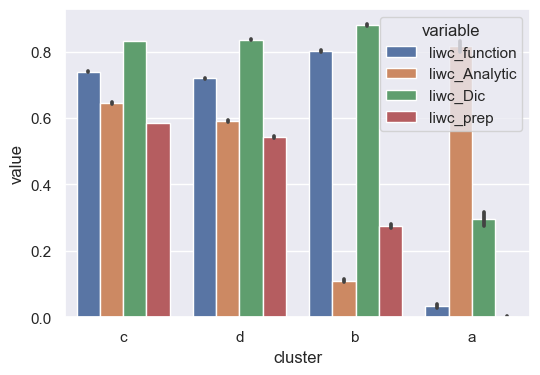

         Variable       Var
20  liwc_function  0.313654
13  liwc_Analytic  0.261927
19       liwc_Dic  0.240698
30      liwc_prep  0.234274
data has 66915 instances
bonforrini_threshold:  0.008333333333333333
exception for feature  All numbers are identical in kruskal


In [233]:
liberal_significancy_result, liberal_predicted_df = run_cluster_analysis(liberal_features_df)

<AxesSubplot:xlabel='effect'>

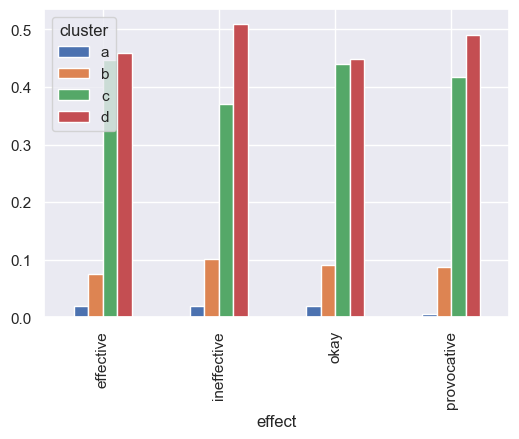

In [234]:

liberal_effect_cluster_df = liberal_predicted_df.merge(liberal_arguments_df[['effect']], 
                                how='inner', left_index= True, right_index=True)
pd.crosstab(liberal_effect_cluster_df['effect'], liberal_effect_cluster_df['cluster'], normalize='index').plot(kind='bar')

## PCA

In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# PREPARE DATA FOR pca


#X_norm = (X - X.min())/(X.max() - X.min())
#X_standardized = StandardScaler().fit_transform(X)
def plot_pca(df, ideology):
    col=df.columns
    features=col.tolist() 
    feature=features[:-1] 
    target=features[-1]
    X=df.loc[:,feature].values  
    y=df.loc[:,target].values
    #Apply Standard Scaling
    sc=StandardScaler()  
    X=sc.fit_transform(X) 
    #pd.DataFrame(X,columns=feature).head()
    #Define two components  
    pca=PCA(n_components=2) 
    principalComponents=pca.fit_transform(X) 
    principalDf=pd.DataFrame(data=principalComponents,columns=['principal component 1','principal component 2']) 
    #principalDf.head()
    finalDf=pd.concat([principalDf,df[['effect']]],axis=1)
    
    fig=plt.figure(figsize=(8,8))  
    ax=fig.add_subplot(1,1,1)  
    ax.set_xlabel('Principal Component 1',fontsize = 15)  
    ax.set_ylabel('Principal Component 2',fontsize = 15)  
    ax.set_title(ideology,fontsize=20)  
    targets=list(df.effect.unique())
    colors= ['b', 'g', 'y', 'm']#sns.color_palette('deep')[:len(targets)]
    for target,color in zip(targets,colors):    
        indicesToKeep = finalDf['effect'] == target  
        ax.scatter(finalDf.loc[indicesToKeep,'principal component 1'],
                  finalDf.loc[indicesToKeep,'principal component 2'],
                 c=color,
                 s=50)
        ax.xaxis.label.set_color('white')
        ax.yaxis.label.set_color('white')
        ax.title.set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.legend(targets)  
        ax.grid()

    
    
    
    


getting only numeric features from the training set...
There are 105  numeric features out of 105
Normalizing by using standard scaler...
getting only numeric features from the training set...
There are 105  numeric features out of 105
Normalizing by using standard scaler...


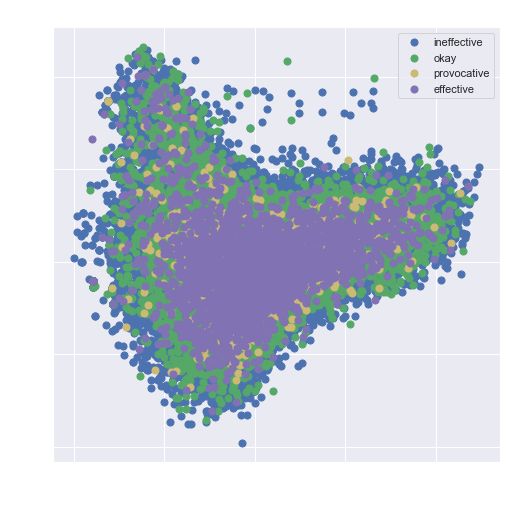

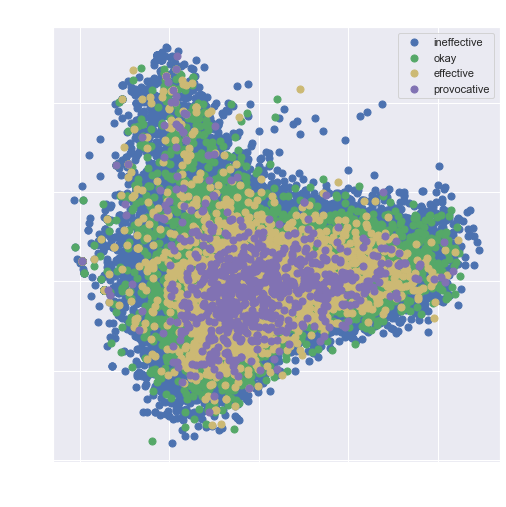

In [301]:
conservative_features_w_effect_df = prepare_data(conservative_features_df, normalizing_method="standard")
conservative_features_w_effect_df = conservative_features_w_effect_df.merge(conservative_arguments_df[['effect']], 
                                                                   how='inner', left_index= True, right_index=True)



liberal_features_w_effect_df = prepare_data(liberal_features_df, normalizing_method="standard")
liberal_features_w_effect_df = liberal_features_w_effect_df.merge(liberal_arguments_df[['effect']], 
                                                                   how='inner', left_index= True, right_index=True)

plot_pca((conservative_features_w_effect_df), 'Conservative')
plot_pca((liberal_features_w_effect_df), 'Liberal')

In [266]:

# example of random oversampling to balance the class distribution
from collections import Counter
undersample(conservative_features_w_effect_df)

Counter({'effective': 906, 'ineffective': 906, 'okay': 906, 'provocative': 906})


,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_sadness,nrc_surprise,nrc_trust,nrc_ratio,nrc_negative,...,liwc_Colon,liwc_SemiC,liwc_QMark,liwc_Exclam,liwc_Dash,liwc_Quote,liwc_Apostro,liwc_Parenth,liwc_OtherP,effect
0,0.123431,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.792389,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,effective
1,4.937245,4.588130,4.302706,4.754947,2.764280,3.454124,4.495917,3.296984,2.267843,4.252626,...,0.472337,0.52628,0.252799,0.000000,0.607523,1.626905,0.423776,0.337952,0.543073,effective
2,3.826365,3.146146,2.048908,2.377473,2.579995,3.289642,3.211369,2.747486,2.312700,4.176686,...,0.332783,0.00000,0.000000,0.000000,0.262194,0.315483,0.096313,0.153615,0.033731,effective
3,0.246862,0.000000,0.409782,0.000000,0.000000,0.000000,0.000000,0.183166,1.618645,0.303759,...,0.654831,0.00000,0.000000,0.292065,0.390093,1.515557,0.000000,0.000000,1.035550,effective
4,0.000000,0.000000,0.000000,0.000000,0.184285,0.000000,0.000000,0.000000,1.105958,0.000000,...,0.000000,0.00000,1.342449,0.000000,0.000000,0.000000,0.741608,0.000000,0.000000,effective
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,0.000000,0.000000,0.000000,0.226426,0.000000,0.493446,0.000000,0.091583,2.149879,0.227819,...,0.000000,0.00000,0.810700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,provocative
3620,0.246862,0.131089,0.000000,0.113213,0.000000,0.493446,0.321137,0.457914,2.481774,0.607518,...,0.000000,0.00000,0.505598,0.000000,0.000000,0.000000,0.000000,0.898646,0.984953,provocative
3621,0.370293,0.131089,0.000000,0.113213,0.000000,0.164482,0.000000,0.000000,2.230894,0.227819,...,0.000000,0.00000,0.000000,0.000000,0.000000,4.268305,0.000000,0.000000,0.000000,provocative
3622,1.357742,0.131089,1.229345,1.358556,0.000000,1.809303,0.963411,0.091583,2.909637,1.063156,...,0.000000,0.00000,0.514315,0.000000,0.000000,1.466070,0.568245,2.273498,0.000000,provocative


# Significance between Effects

In [241]:
def calc_sign_effects(df, ideology):
    return significance_testing.significance(df, save=True, 
                                          desc='../data/significant_test/{}_effect'.format(ideology),
                                          independent_var='effect')


conservative_features_w_effect_df = prepare_data(conservative_features_df, normalizing_method="standard")
conservative_features_w_effect_df = conservative_features_w_effect_df.merge(conservative_arguments_df[['effect']], 
                                                                   how='inner', left_index= True, right_index=True)

liberal_features_w_effect_df = prepare_data(liberal_features_df, normalizing_method="standard")
liberal_features_w_effect_df = liberal_features_w_effect_df.merge(liberal_arguments_df[['effect']], 
                                                                   how='inner', left_index= True, right_index=True)

getting only numeric features from the training set...
There are 105  numeric features out of 105
Normalizing by using standard scaler...
getting only numeric features from the training set...
There are 105  numeric features out of 105
Normalizing by using standard scaler...


In [269]:
conservative_significance_effect = calc_sign_effects(undersample(conservative_features_w_effect_df), 'conservative_undersampled')
liberal_significance_effect = calc_sign_effects(undersample(liberal_features_w_effect_df), 'liberal_undersampled')

Counter({'effective': 906, 'ineffective': 906, 'okay': 906, 'provocative': 906})
data has 3624 instances
bonforrini_threshold:  0.008333333333333333
exception for feature  All numbers are identical in kruskal
Counter({'effective': 819, 'ineffective': 819, 'okay': 819, 'provocative': 819})
data has 3276 instances
bonforrini_threshold:  0.008333333333333333
exception for feature  All numbers are identical in kruskal


In [281]:
cons_discriminative_vals = conservative_significance_effect[conservative_significance_effect['effective ineffective']>0.1
                                ].sort_values(by=['effective ineffective'], ascending=False).index.values.tolist()

cons_discriminative_vals = ', '.join(cons_discriminative_vals)
cons_discriminative_vals

'liwc_netspeak, liwc_AllPunc, liwc_WC, liwc_Dash, liwc_OtherP, nrc_anger, nrc_disgust, nrc_fear, nrc_negative, liwc_number'

In [286]:
lib_discriminative_vals = liberal_significance_effect[liberal_significance_effect['effective ineffective']>0.09
                                ].sort_values(by=['effective ineffective'], ascending=False).index.values.tolist()

lib_discriminative_vals = ', '.join(lib_discriminative_vals)
lib_discriminative_vals

'liwc_AllPunc, liwc_shehe, liwc_OtherP'